# Liver segmentation with nitrain

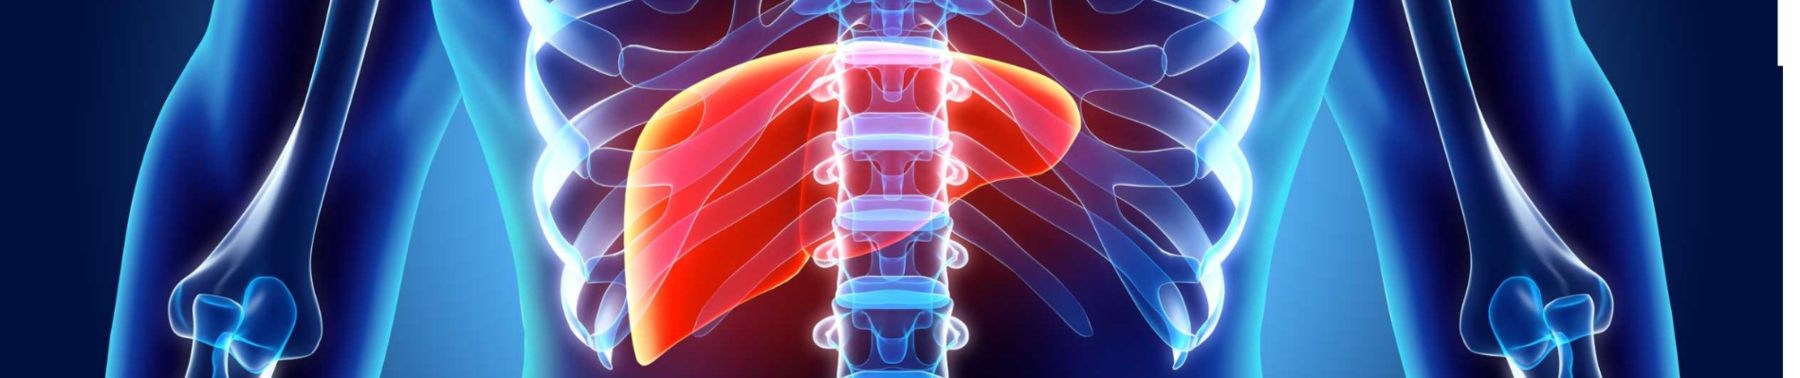

This example shows you how to train a model to perform liver segmentation using nitrain. It is a classic example of medical image segmentation. 

We will create a model with keras and do everything else (data sampling + augmentation, training, explaining results) with nitrain.

## About the data

The dataset can be downloaded from the [Liver Tumor Segmentation](https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation/data) dataset on Kaggle. It is about 5 GB in size and contains 130 CT scans of the liver along with associated segmentation images identifying the liver and also tumors within the liver. We will only use the liver segmentation for this example.

To run this example, download the dataset ("archive.zip") and unpack it onto your desktop. Then we are ready to go!

## Creating a dataset

Since we have the images in a local folder and they are not in any special format, we can use the `FolderDataset` class to load them into memory. We want to use the raw images as inputs and the segmentated images as outputs.

The data looks like this:

```md
kaggle-liver-ct/
    volumes/
        volume-0.nii
        volume-1.nii
        ...
        volume-10.nii
    sgementations/
        segmentation-0.nii
        segmentation-1.nii
        ...
        segmentation-10.nii
```

Notice in particular how the images follow a specific pattern with the participant id located at the end of the file. We will use this to make sure the volumes and segmentations are correctly matched.

In [1]:
from nitrain.datasets import FolderDataset

dataset = FolderDataset('~/Desktop/kaggle-liver-ct',
                        x={'pattern': 'volumes/volume-{id}.nii'},
                        y={'pattern': 'segmentations/segmentation-{id}.nii'})
x, y = dataset[0]
print(x)
print(y)

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 75)
	 Spacing    : (0.7031, 0.7031, 5.0)
	 Origin     : (-172.9, 179.2969, -368.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 75)
	 Spacing    : (0.7031, 0.7031, 5.0)
	 Origin     : (-172.9, 179.2969, -368.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]



Specifying '{id}' in the patterns as we did was not strictly necessary in this case, but it's a good practice to get in the habit of doing.

In any case, we can now read in the raw images by indexing our dataset. Let's now think about any fixed (i.e., non-random) pre-processing that we may want to perform on these images. Any transforms we pass to the dataset instance will be performed after we read in the images but can be cached so that the images only have to be processed once.

### Applying fixed transforms

We don't need to do much pre-processing of the images to get them into a format ready for training. To make things easier for the model, we will normalize the intensity of the input image to be between 0 and 1. 

The segmentation images have a value of 1 if the voxel is part of the liver and a value of 2 if the voxel is part of a tumor in the liver. The segmentation image has a value of 0 otherwise (i.e., any part of the image that is non-liver). Since we only care about the liver segmentation, we can add a custom transform to basically disregard the extra information about tumors.

Additionally, we will downsample both the input image and its segmentation to a smaller size to make training go faster. Finally, we will reorient the images so that the correct view of the image along the inferior - posterior axis is used to train the model. You can think of this as cross-sections of the abdomen going successively down the spine.

In [3]:
from nitrain import transforms as tx
dataset = FolderDataset('~/Desktop/kaggle-liver-ct',
                        x={'pattern': 'volumes/volume-{id}.nii'},
                        y={'pattern': 'segmentations/segmentation-{id}.nii'},
                        x_transforms=[tx.RangeNormalize(0, 1)],
                        y_transforms=[tx.CustomFunction(lambda x: x > 0)],
                        co_transforms=[tx.Resample((128, 128, 64)),
                                       tx.Reorient('IPR')])

x, y = dataset[0]
print(x)
print(y)

ANTsImage (IPR)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 128, 128)
	 Spacing    : (5.873, 2.8291, 2.8291)
	 Origin     : (-172.9, 179.2969, -368.0)
	 Direction  : [ 0.  0.  1.  0. -1.  0.  1.  0.  0.]

ANTsImage (IPR)
	 Pixel Type : unsigned char (uint8)
	 Components : 1
	 Dimensions : (64, 128, 128)
	 Spacing    : (5.873, 2.8291, 2.8291)
	 Origin     : (-172.9, 179.2969, -368.0)
	 Direction  : [ 0.  0.  1.  0. -1.  0.  1.  0.  0.]



## Creating a loader

Now that we have a dataset, we can pass it into a loader. When you are creating a loader, you should always think about two things:

- whether you will train on the entire image or slices / blocks / patches of it
- whether you will apply data augmentation

In this case, we want to train on full 2D slices of the 3D images. Therefore, we want to split our image of size (64, 128, 128) into 64 slices of size (128, 128). This is normally quite cumbersome to do and also difficult to get right. The sampler classes in nitrain make this easy.

### Slice sampling

We will use the `SliceSampler` class to ensure that our loader serves batches of 2D slices from our images.

In [4]:
from nitrain.samplers import SliceSampler
sampler = SliceSampler(batch_size=24, axis=0)

This takes care of the first question. Note that if you wanted to train on the entire image, then there is no need to use a sampler.

### Applying random transforms

Next, we will create some random transforms to perform data augmentation during training. This means that our images will be randomly altered only slightly every time a batch is generated. If done correctly, this will greatly increase the diversity of the images that our model sees and in turn lead to greater model performance and generalizability.

Here, we will apply some random intensity transforms to alter the pixel values of our 2D slice, as well as random spatial transforms to alter how the image structure appears. As with the fixed transforms we applied to the dataset, these transforms can be applied to only the input image, only the output image, or both images together.

In [ ]:
x_transforms = []
y_transforms = []
co_transforms = []

### Finalizing the loader

Now that we have the sampler and the random transforms, we can create our loader. 

In [ ]:
from nitrain.loaders import DatasetLoader
loader = DatasetLoader(dataset, 
                       images_per_batch=4,
                       x_transforms=x_transforms,
                       y_transforms=y_transforms,
                       co_transforms=co_transforms,
                       sampler=sampler)

## Creating a model

Now that we know how our data will be served during batch generation, it is time to think about the model. We know that our model must take in an image of size (128, 128, 1) and return a a segmented version of that input image. The input image will be a continuous-valued image, but what will the output image look like?

We are performing segmentation - a type of classification problem. Therefore, we want to actually return an image "channel" for each possible segmentation class. Here, we have two possible classes (non-tumor versus tumor), so we will return an image of size (128, 128, 2). 

Moreover, the channels should represent probabilities of the given pixel belonging to that class and the two channels should sum to one for any given pixel. 

### Choosing an architecture

The nitrain library has a large variety of architectures to choose from. For this example, we can simply use the Unet model. Let's create that architecture

In [ ]:
from nitrain.models import fetch_architecture

arch_fn = fetch_architecture('unet', dim=2, framework='keras')
model = arch_fn((128, 128, 1))

Note that we used the Keras framework here, but pytorch is also available for many architectures.

## Training the model

Now that we have a loader and a model, we can create a trainer and actually perform the training. We will train the model locally here, but it is also possible to train the model in the cloud using either your own cloud account or on the nitrain.dev platform. 

Using the nitrain.dev platform is a good option because it takes care of all the work required to train models in the cloud. It will also cache your dataset temporarily if you want to trying training the model multiple times. This greatly speeds up your workflow.

In [ ]:
from nitrain.trainers import LocalTrainer
trainer = LocalTrainer(model=model, task='segmentation')

By setting the task to "segmentation" in the trainer, it will automatically give us sensible defaults for the model loss, learning rate, optimizer, metrics, and so on. It is of course possible to set those parameters manually, however.

Let's train the model for 20 epochs.

In [ ]:
trainer.fit(loader, epochs=20)

## Visualizing results